## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [ ]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from main.features import add_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
    .reset_index(drop=True)
)

## **Random Forest Regression**

In [4]:
def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    test = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    test['trend'] = test.index + train.index.max() + 1
    
    m = RandomForestRegressor(n_estimators=1000, random_state=1001)
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    test['y_pred'] = m.predict(X=test.iloc[:,3:])

    return test

In [5]:
# aplicando modelo para cada série
rf_fcst = features_train_df.groupby("unique_id").apply(random_forest).reset_index(drop=True)

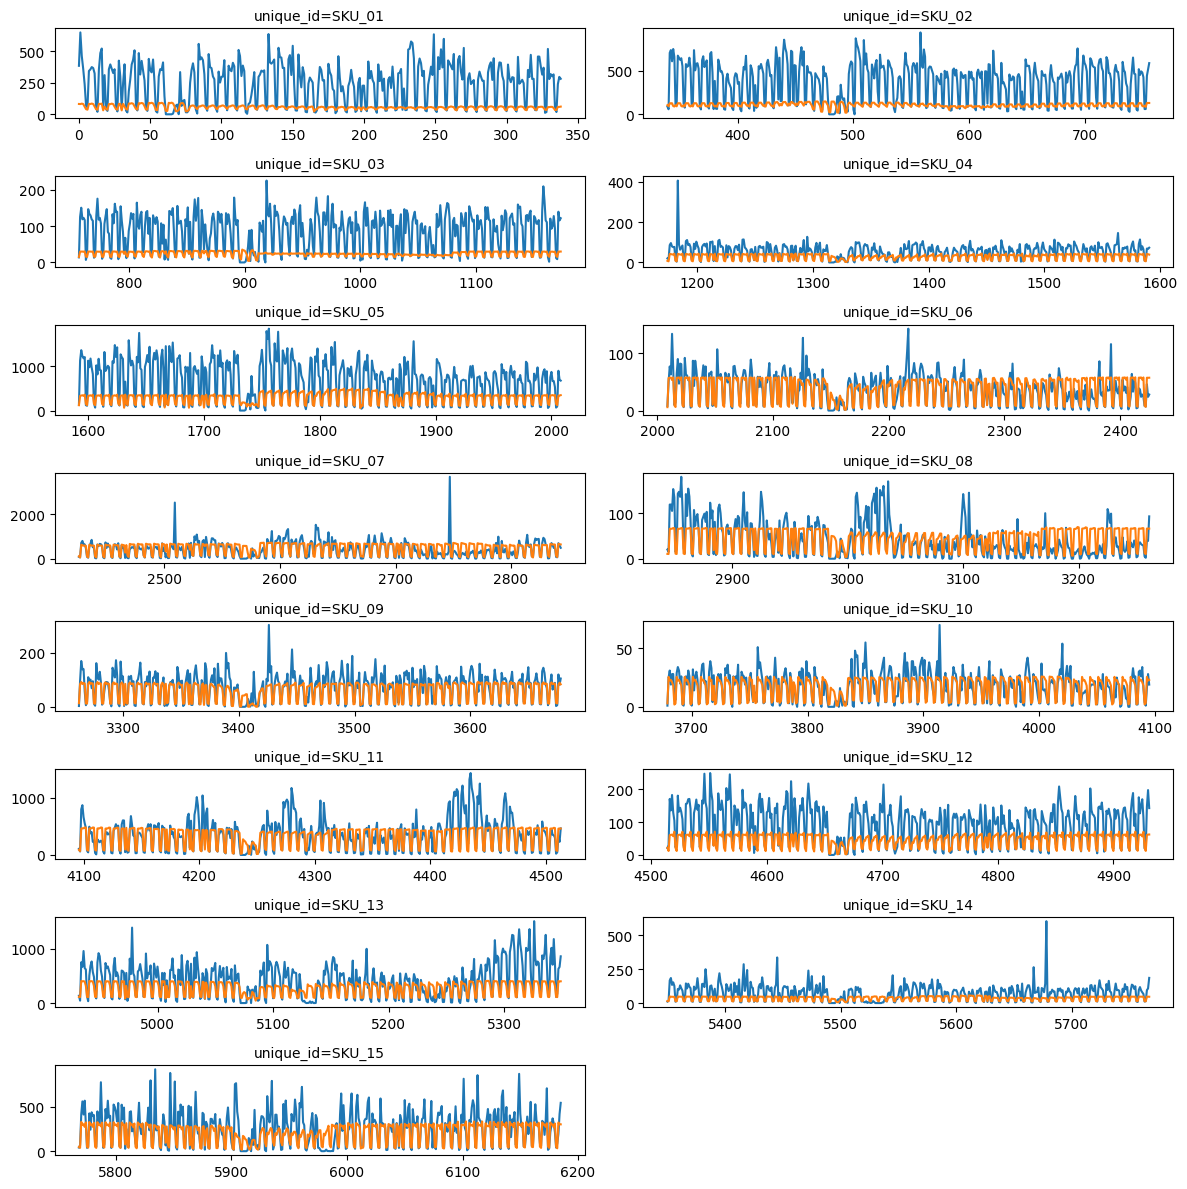

In [6]:
plot_time_series(
    df = rf_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [7]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,196.56,60723.58,246.42,-1.15
SKU_02,282.87,119096.47,345.10,-1.28
SKU_03,63.60,6089.77,78.04,-1.16
SKU_04,26.52,1427.24,37.78,0.02
SKU_05,425.08,295972.44,544.03,-0.39
SKU_06,12.21,297.60,17.25,0.58
SKU_07,186.46,87534.09,295.86,0.39
SKU_08,24.28,1116.16,33.41,0.34
SKU_09,21.31,1073.43,32.76,0.59
SKU_10,5.62,62.83,7.93,0.61


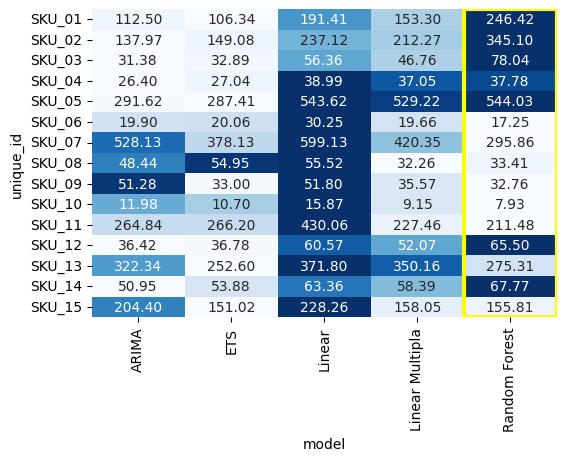

In [ ]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')
plot_metrics(metrics, hl_col='Random Forest', figsize=(6, 4))